<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Overfit Artificial Neural Networks 

#### Laaiba Akmal
#### The Hildebrand Department of Petroleum Engineering at the University of Texas at Austin 

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

This project demonstrates the use of Artificial Neural Netrworks (ANNs) in building overfit models when given a noisy data set. The question being answered is whether building a more complicated Neural Network will yield a more accurate result or if it will be prone to more overfit. Initially, I built a Neural Network to train the data set and quantify the overfit of my model. To understand the response with increased ANN complexity, I sequentially added more hidden layers to the Neural Network and determined the overfit. I expect greater overfit with more complex models.This workflow is a demonstration of this hypothesis. From my results, I believe that this is true to a certain extent. Since I ran into some trouble with training my model, more work needs to be done to validate this hypothesis. My recommendation is to explore different Neural Network Architectures (Shrinking, Growing and Shrinking etc) and observe the trends in overfit with increased complexity. It would also be beneficial to carry out this test with a greater number of ANNs with varying complexities on different data sets to observe the results. 

### Import Packages

In order to design and train the Neural Networks, the following packages should be imported:

In [539]:
import numpy as np                                        # for working with data and model arrays
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf                     #Tensorflow with Keras module is imported to build, test and train neural nets
import keras
from keras import Model, Input
from keras.layers import Dense, BatchNormalization
from sklearn.model_selection import train_test_split

### Functions

The following functions will be used in the workflow

#### a) Activation Function: ReLU Function

The rectified linear units function (ReLU) is used as the activation function throughout this workflow. This function ranges from 0 to infinity. When the input is positive, the ouput is the same as the input. In any other case, the output is 0. This function is used within the Neural Net Function

## \begin{equation}
f(x) = max(0, x)
\end{equation}


#### b) Plot Loss Function used for the evaluation of the model 

In [540]:
def plot_loss(fit):
    epochs     = len(fit.history['loss'])
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'],     '-', label='loss')
    plt.plot(iterations, fit.history['val_loss'], '-', label='validation loss')
    plt.ylim(0,0.4)
    plt.legend(['train', 'test'], loc='upper right')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xticks(iterations[::epochs//10])

#### c) General Neural Net Function:
This is a general format of the ANN functions used throughout this workflow.
Each x represents a layer of the neural net.
The units describe the number of nodes in each layer.

In [541]:
def my_nn():                                          
    keras.backend.clear_session()
    inp = Input(shape=(2))
    x   = Dense(units=2000, activation='relu')(inp)
    x   = Dense(units=1000, activation='relu')(x)
    x   = Dense(units=2, activation='relu')(x)
    out = Dense(units=1)(x)
    return Model(inp, out)  

### Load Data

The following workflow applies the .csv file 'unconv_MV_v5.csv', a subsurface data set, taken from Dr.Pyrcz's Github Repository.

This data set is modified to obtain the following features.

* **acoustic impedence** - product of sonic velocity and rock density in unitsof $kg/m^2s*10^3
* **brittleness** - parameter that controls the mechanical behavior and failure characteristics of rocks under loading and unloading conditions

In this workflow, acoustic impedence (AI) is used as a predictor feature and Brittleness is used as a response feature for model predictions. We are training the ANNs to determine the Britleness at given AI values. 

In [542]:
df0 = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv')
df0.describe().T
data = df0    
np.random.seed(500)
noise = np.random.normal(0,0.1,[200,2])                          #adding noise to the data set 
df = df0.iloc[:200, 3:5] +noise
df

,AI,Brittle
0,2.762264,81.416676
1,3.288280,46.362138
2,3.990296,72.724012
3,2.421093,39.806363
4,3.058225,10.797109
...,...,...
195,2.900847,67.240924
196,3.415582,44.326289
197,3.577384,57.109878
198,2.412192,58.400699


In [543]:
#normalizing the data set; this is done to remove the sensitivity of the features and improve the function of the activaction function
#the predictor and response features are normalized so that they are bounded [-1,1]
AI_min = df['AI'].values.min(); AI_max = df['AI'].values.max()
Brittle_min = df['Brittle'].values.min(); Brittle_max = df['Brittle'].values.max()
df['norm_AI'] = (df['AI'] - AI_min)/(AI_max - AI_min) * 2 - 1
df['norm_Brittle'] = (df['Brittle'] - Brittle_min)/(Brittle_max - Brittle_min) * 2 - 1
df.head()

,AI,Brittle,norm_AI,norm_Brittle
0,2.762264,81.416676,-0.111445,0.922289
1,3.288280,46.362138,0.184945,-0.031907
2,3.990296,72.724012,0.580504,0.685672
3,2.421093,39.806363,-0.303682,-0.210358
4,3.058225,10.797109,0.055318,-1.000000


In [544]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AI,200.0,2.968689,0.585864,1.185307,2.515424,2.952535,3.335294,4.734794
Brittle,200.0,48.162523,14.146601,10.797109,37.679365,49.460398,58.322260,84.271545
norm_AI,200.0,0.004867,0.330112,-1.000000,-0.250530,-0.004235,0.211435,1.000000
norm_Brittle,200.0,0.017100,0.385075,-1.000000,-0.268256,0.052428,0.293651,1.000000


# ANN General Workflow 

In this project, I reviewed a few different ANN architectures to test out my hopothesis. They all had a shrinking architecture.Below, I have documented one of the architectures.   

Note: The following code was made using the steps outlined from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_NeuralNet.ipynb as well as Interactive_NeuralNetwork_SingleLayer.ipynb from GeostatsGuy GitHub.   


## 1. Separation of Training and Testing Data


In [545]:
#data is split into training data (80% of the data) and testing data (20% of the data)
X2 = df.iloc[:,[0,2]]                        # extract the predictor feature - acoustic impedance
y2 = df.iloc[:,[1,3]]                        # extract the response feature - brittleness
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=73073)

#### Visualize the Dataset
The train and test data split is visualized on a single scatter plot.
AI vs Brittleness is plotted below, along with Normalized AI and Normalized Brittleness.

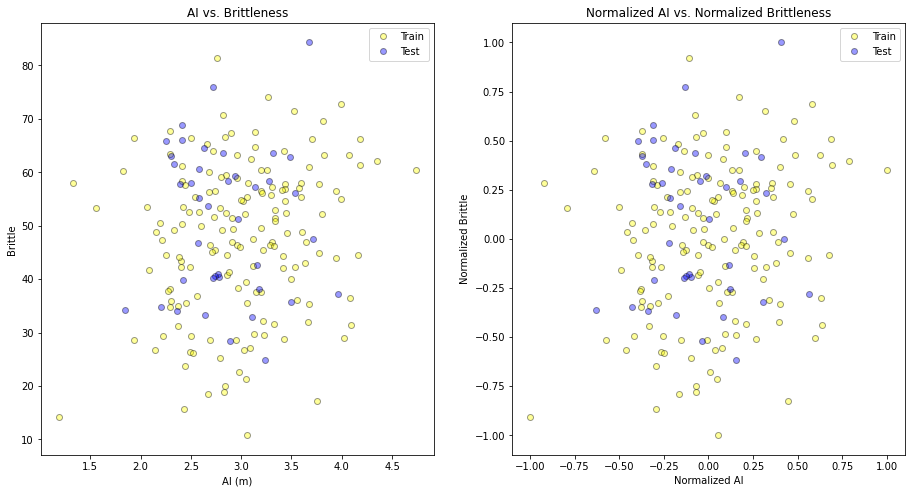

In [546]:
## code modified from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_NeuralNet.ipynb
plt.subplot(121)
plt.plot(X2_train['AI'].values,y2_train['Brittle'].values, 'o', markerfacecolor='yellow', markeredgecolor='black', alpha=0.4, label = "Train")
plt.plot(X2_test['AI'].values,y2_test['Brittle'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=0.4, label = "Test")
plt.title('AI vs. Brittleness')
plt.xlabel('AI (m)')
plt.ylabel('Brittle')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

plt.subplot(122)
plt.plot(X2_train['norm_AI'].values,y2_train['norm_Brittle'].values, 'o', markerfacecolor='yellow', markeredgecolor='black', alpha=0.4, label = "Train")
plt.plot(X2_test['norm_AI'].values,y2_test['norm_Brittle'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=0.4, label = "Test")
plt.title('Normalized AI vs. Normalized Brittleness')
plt.xlabel('Normalized AI')
plt.ylabel('Normalized Brittle')
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.3)
plt.show()

In [547]:
# The prediction locations for our ANN models are specified as follows:
nbins = 1000
AI_bins = np.linspace(AI_min, AI_max, nbins) # set the bins for prediction
norm_AI_bins = (AI_bins-AI_min)/(AI_max-AI_min)*2-1 # use normalized bins

## 2. Building the Neural Nets (with increasing complexity) for prediction modelling 
The following portion reviews the Shrinking Architecture of Artificial Neural Networks. We are defining 4 functions that are to be used to model prediction in the next step. In each case, we are starting with a layer containing the largest number of nodes and shrinking to our final layer with a single node. There is an increase in complexity from ANN 1 to ANN 4. 

In [548]:
#Shrinking ANN x1 (Least Complex): 
def my_nnx1():
    keras.backend.clear_session()
    inp = Input(shape=(1))
    x   = Dense(units= 5, activation='relu')(inp)
    out = Dense(units=1)(x)
    return Model(inp, out)


#Shrinking ANN x2 
def my_nnx2():
    keras.backend.clear_session()
    inp = Input(shape=(1))
    x   = Dense(units= 10, activation='relu')(inp)
    x   = Dense(units= 5, activation='relu')(x)  
    out = Dense(units=1)(x)
    return Model(inp, out)


#Shrinking ANN x3
def my_nnx3():
    keras.backend.clear_session()
    inp = Input(shape=(1))
    x   = Dense(units=15, activation='relu')(inp)  
    x   = Dense(units=10, activation='relu')(x)
    x   = Dense(units=5, activation='relu')(x)
    out = Dense(units=1)(x)
    return Model(inp, out)

#Shrinking ANN x4
def my_nnx4():
    keras.backend.clear_session()
    inp = Input(shape=(1))
    x   = Dense(units=20, activation='relu')(inp)
    x   = Dense(units=10, activation='relu')(x)  
    x   = Dense(units=5, activation='relu')(x)
    x   = Dense(units=5, activation='relu')(x)
    out = Dense(units=1)(x)
    return Model(inp, out)

### 3. Compiling the Machines and Training the Network

In this section, we first compile the machine by specify the optimizer, loss function and the metric for model training.
The Adam optimization algorithm is used and it is an extension to stochastic gradient descent.

We then fit the model parameters within a specified number of epochs. We specify the train and test normalized predictor and response features.

A learning rate of 0.01 to 0.001 can be used ( we have used 0.03 in the cases below).
The Rate of decay parameters of $\beta_1=0.9$ and $\beta_2=0.999$ are used.

In [549]:
#Selecting the Optimizer
tf.keras.optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#ANN x1:

#Compiling the Machine
modelx1 = my_nnx1()
print('Number of parameters for ANN x1: {:,}'.format(modelx1.count_params()))

modelx1.compile(optimizer = 'adam',
              loss      = 'mse',
              metrics   = ['mse'])
#Training the Network
hist_1 = modelx1.fit(X2_train['norm_AI'], y2_train['norm_Brittle'],
    batch_size=5, epochs=200,
    validation_data=(X2_test['norm_AI'], y2_test['norm_Brittle']),verbose = 0)


#ANN x2:

#Compiling the Machine
modelx2 = my_nnx2()
print('Number of parameters for ANN x2: {:,}'.format(modelx2.count_params()))

modelx2.compile(optimizer = 'adam',
              loss      = 'mse',
              metrics   = ['mse'])
#Training the Network 
hist_2 = modelx2.fit(X2_train['norm_AI'], y2_train['norm_Brittle'],
    batch_size=5, epochs=200,
    validation_data=(X2_test['norm_AI'], y2_test['norm_Brittle']),verbose = 0)


#ANN x3:

#Compiling the Machine
modelx3 = my_nnx3()
print('Number of parameters for ANN x3: {:,}'.format(modelx3.count_params()))

modelx3.compile(optimizer = 'adam',
              loss      = 'mse',
              metrics   = ['mse'])
#Training the Network 
hist_3 = modelx3.fit(X2_train['norm_AI'], y2_train['norm_Brittle'],
    batch_size=5, epochs=200,
    validation_data=(X2_test['norm_AI'], y2_test['norm_Brittle']),verbose = 0)


#ANN x4
modelx4 = my_nnx4()
print('Number of parameters for ANN x4: {:,}'.format(modelx4.count_params()))

modelx4.compile(optimizer = 'adam',
              loss      = 'mse',
              metrics   = ['mse'])

hist_4 = modelx4.fit(X2_train['norm_AI'], y2_train['norm_Brittle'],
    batch_size=5, epochs=200,
    validation_data=(X2_test['norm_AI'], y2_test['norm_Brittle']),verbose = 0)

p1 = modelx1.count_params()
p2 = modelx2.count_params()
p3 = modelx3.count_params()
p4 = modelx4.count_params()
parameters = [p1,p2,p3,p4]
#print(parameters)

Number of parameters for ANN x1: 16
Number of parameters for ANN x2: 81
Number of parameters for ANN x3: 251
Number of parameters for ANN x4: 341


#### The Artificial Neural Network Design and Paratmeters are summarized as follows:

In [550]:
print('Model Summary of ANN x1')
modelx1.summary()
print('Model Summary of ANN x2')
modelx2.summary()
print('Model Summary of ANN x3')
modelx3.summary()
print('Model Summary of ANN x4')
modelx4.summary()

Model Summary of ANN x1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 5)                 10        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
Model Summary of ANN x2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 d

## 4. Model Predictions using the Neural Networks 
The trained models are used to make predictions at the prediction locations specified earlier in the workflow. 
The effect of normalization is removed from the features. 
For each ANN, the graph of the Model Prediction is plotted below. 

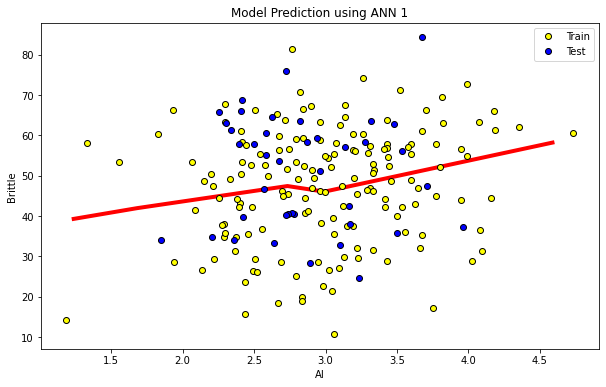

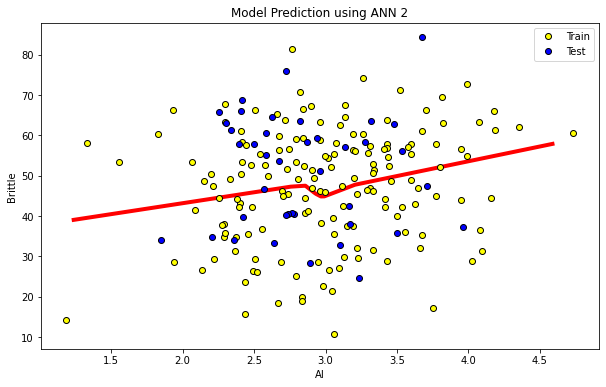

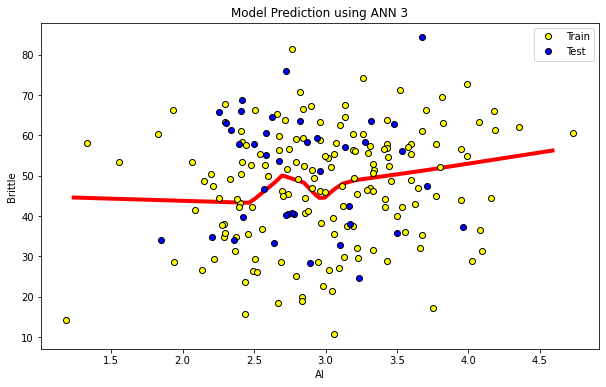

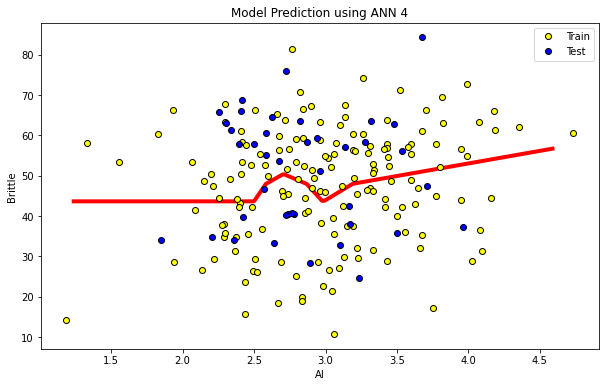

<Figure size 432x288 with 0 Axes>

In [551]:
from matplotlib.pyplot import figure

## code modified from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_NeuralNet.ipynb
pred_norm_Brittle1 = modelx1.predict(np.array(norm_AI_bins)) # predict with our ANN
pred_Brittle1 = ((pred_norm_Brittle1 + 1)/2*(Brittle_max - Brittle_min)+Brittle_min)

pred_norm_Brittle2 = modelx2.predict(np.array(norm_AI_bins)) # predict with our ANN
pred_Brittle2 = ((pred_norm_Brittle2 + 1)/2*(Brittle_max - Brittle_min)+Brittle_min)

pred_norm_Brittle3 = modelx3.predict(np.array(norm_AI_bins)) # predict with our ANN
pred_Brittle3 = ((pred_norm_Brittle3 + 1)/2*(Brittle_max - Brittle_min)+Brittle_min)

pred_norm_Brittle4 = modelx4.predict(np.array(norm_AI_bins)) # predict with our ANN
pred_Brittle4 = ((pred_norm_Brittle4 + 1)/2*(Brittle_max - Brittle_min)+Brittle_min)

figure(figsize=(10,6)) 
plt.plot(depth_bins,pred_Brittle1,'red',linewidth=4)
plt.plot(X2_train['AI'].values,y2_train['Brittle'].values, 'o', markerfacecolor='yellow', markeredgecolor='black', alpha=1.0, label = "Train")
plt.plot(X2_test['AI'].values,y2_test['Brittle'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=1.0, label = "Test")
plt.xlabel('AI')
plt.ylabel('Brittle')
plt.title("Model Prediction using ANN 1")
plt.legend()
plt.show()

figure(figsize=(10,6)) 
plt.plot(depth_bins,pred_Brittle2,'red',linewidth=4)
plt.plot(X2_train['AI'].values,y2_train['Brittle'].values, 'o', markerfacecolor='yellow', markeredgecolor='black', alpha=1.0, label = "Train")
plt.plot(X2_test['AI'].values,y2_test['Brittle'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=1.0, label = "Test")
plt.xlabel('AI')
plt.ylabel('Brittle')
plt.title("Model Prediction using ANN 2")
plt.legend()
plt.show()

figure(figsize=(10,6)) 
plt.plot(depth_bins,pred_Brittle3,'red',linewidth=4)
plt.plot(X2_train['AI'].values,y2_train['Brittle'].values, 'o', markerfacecolor='yellow', markeredgecolor='black', alpha=1.0, label = "Train")
plt.plot(X2_test['AI'].values,y2_test['Brittle'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=1.0, label = "Test")
plt.xlabel('AI')
plt.ylabel('Brittle')
plt.title("Model Prediction using ANN 3")
plt.legend()
plt.show()

figure(figsize=(10,6)) 
plt.plot(depth_bins,pred_Brittle4,'red',linewidth=4)
plt.plot(X2_train['AI'].values,y2_train['Brittle'].values, 'o', markerfacecolor='yellow', markeredgecolor='black', alpha=1.0, label = "Train")
plt.plot(X2_test['AI'].values,y2_test['Brittle'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=1.0, label = "Test")
plt.xlabel('AI')
plt.ylabel('Brittle')
plt.title("Model Prediction using ANN 4")
plt.legend()
plt.show()


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

## 5: Model Evaluation- Prediction vs True Data 
Another method to visualise the predicted model is by plotting the predicted values against the true values of the testing and training data. 

In an ideal model (that could very well be overfit), the points would fall along the line y = x.  
A good model would have data points fall relatively close to the line y = x. 
A poor model would have very weak correlation between the predicted data and true data, where few points would fall along the line y = x. 

The ANNs used in this workflow are evaluated as poor models. 

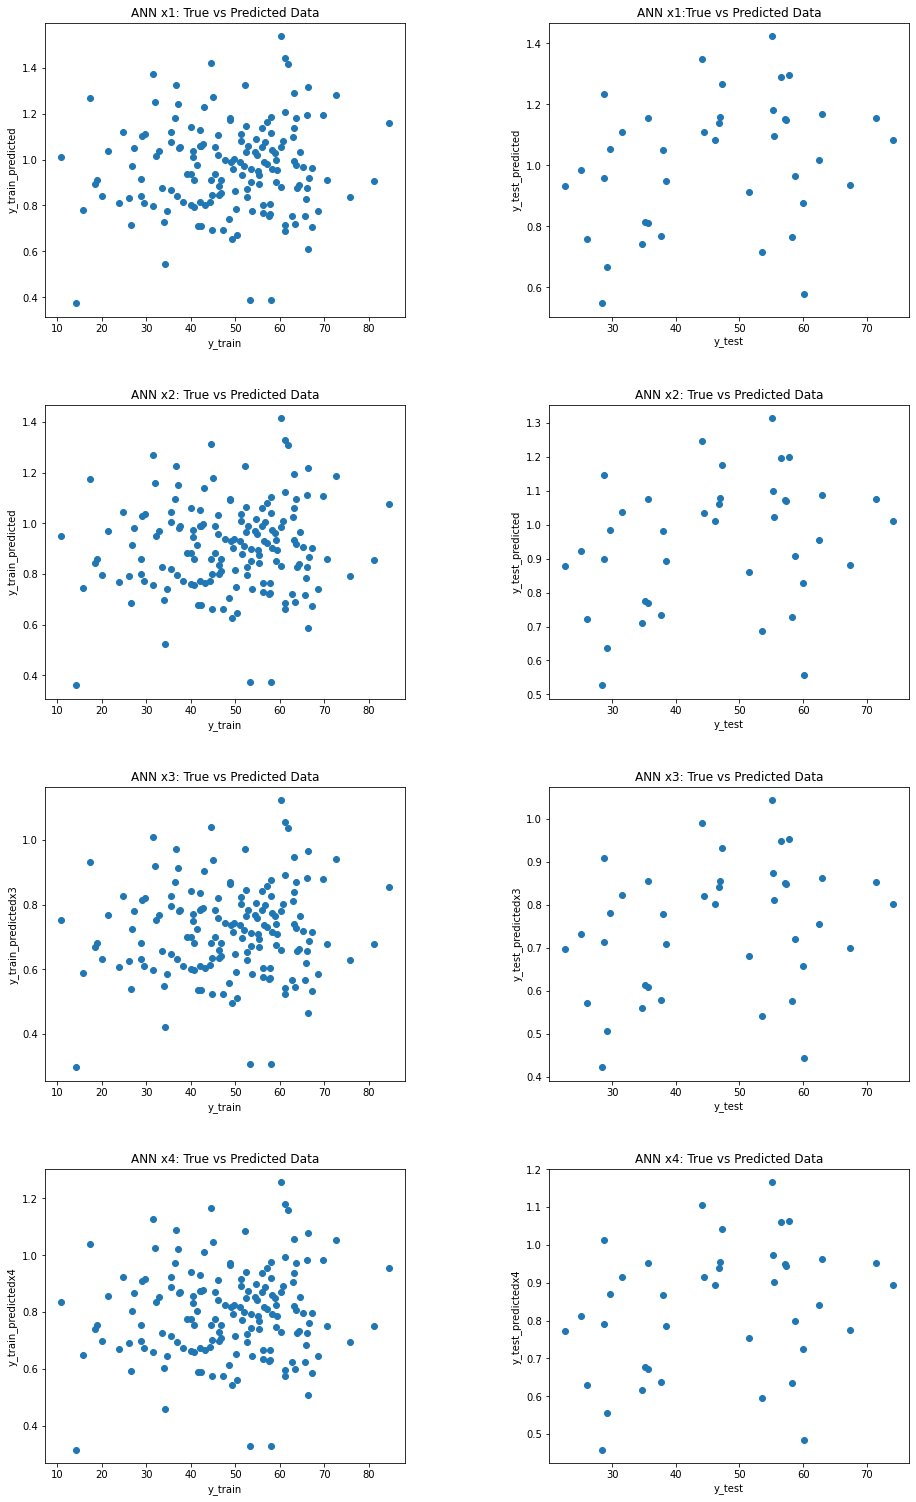

In [552]:
#ANN x1 
y_train_predx1 = modelx1.predict(X_train)
y_test_predx1  = modelx1.predict(X_test)

plt.subplot(421)
plt.title('ANN x1: True vs Predicted Data')
plt.scatter(y_train, y_train_predx1)
plt.xlabel('y_train') 
plt.ylabel('y_train_predicted') 

plt.subplot(422)
plt.title("ANN x1:True vs Predicted Data")
plt.scatter(y_test, y_test_predx1)
plt.xlabel('y_test') 
plt.ylabel('y_test_predicted')


#ANN x2 
y_train_predx2 = modelx2.predict(X_train)
y_test_predx2  = modelx2.predict(X_test)

plt.subplot(423)
plt.title('ANN x2: True vs Predicted Data')
plt.scatter(y_train, y_train_predx2)
plt.xlabel('y_train') 
plt.ylabel('y_train_predicted') 

plt.subplot(424)  
plt.title("ANN x2: True vs Predicted Data")
plt.scatter(y_test, y_test_predx2)
plt.xlabel('y_test') 
plt.ylabel('y_test_predicted')


#ANN x3
y_train_predx3 = modelx3.predict(X_train)
y_test_predx3  = modelx3.predict(X_test)

plt.subplot(425)
plt.title('ANN x3: True vs Predicted Data')
plt.scatter(y_train, y_train_predx3)
plt.xlabel('y_train') 
plt.ylabel('y_train_predictedx3') 

plt.subplot(426)
plt.title("ANN x3: True vs Predicted Data")
plt.scatter(y_test, y_test_predx3)
plt.xlabel('y_test') 
plt.ylabel('y_test_predictedx3')

#ANN x4

y_train_predx4 = modelx4.predict(X_train)
y_test_predx4  = modelx4.predict(X_test)

plt.subplot(427)
plt.title('ANN x4: True vs Predicted Data')
plt.scatter(y_train, y_train_predx4)
plt.xlabel('y_train') 
plt.ylabel('y_train_predictedx4') 

plt.subplot(428)
plt.title("ANN x4: True vs Predicted Data")
plt.scatter(y_test, y_test_predx4)
plt.xlabel('y_test') 
plt.ylabel('y_test_predictedx4')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=5.0, wspace=0.4, hspace=0.3)

## 6. Loss vs Training Epochs
Another method of evaluating the inaccuracy of the data is to observe the trend in Loss over Epochs in both the testing and training data as ANN complexity increases. It is expected that the Loss decreases over Epoch.

The equation of the loss function is as follows and is defined in the plot_loss at the beginning of the workflow. 

* **square loss** ($L_2$ loss) is the:

\begin{equation}
L_2 = \sum_{\bf{u}_{\alpha} \in AOI} \left(y(\bf{u}_{\alpha}) - \hat{f}(x_1(\bf{u}_{\alpha}),\ldots,x_m(\bf{u}_{\alpha})\right)
\end{equation}

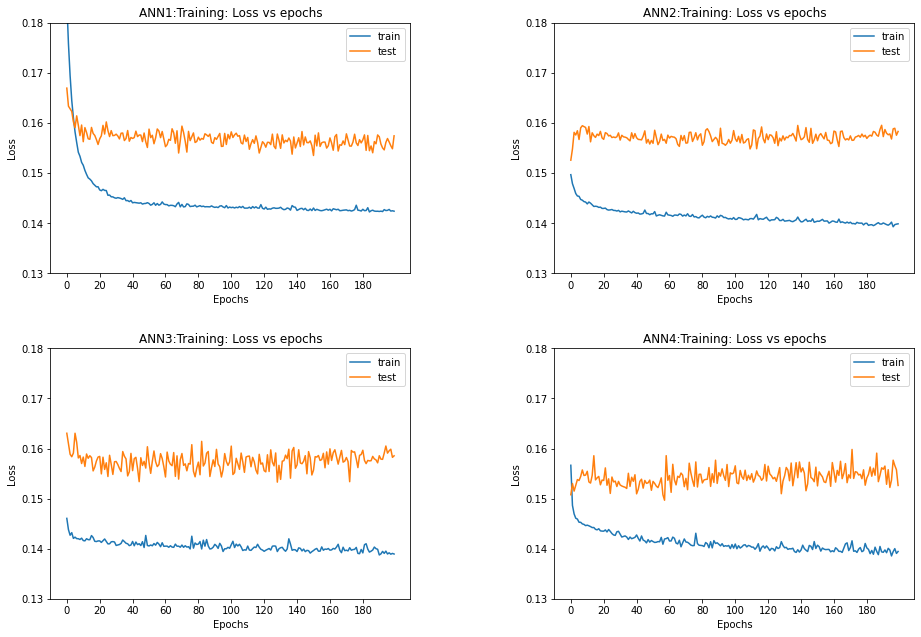

In [553]:
plt.subplot(221)
plot_loss(hist_x1)
plt.title('ANN1:Training: Loss vs epochs'); 
plt.ylim(0.13,0.18)

plt.subplot(222)
plot_loss(hist_x2)
plt.title('ANN2:Training: Loss vs epochs'); 
plt.ylim(0.13,0.18)

plt.subplot(223)
plot_loss(hist_x3)
plt.title('ANN3:Training: Loss vs epochs'); 
plt.ylim(0.13,0.18)

plt.subplot(224)
plot_loss(hist_x4)
plt.title('ANN4:Training: Loss vs epochs'); 
plt.ylim(0.13,0.18) 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)


The model does not match the training data. The loss of both the training and testing data fluctuate and the difefrence between the two is sustained over the number of Epochs. This tells us that the model makes little progress over Epoch. 

## 7.Quantifying Overfit 

### Quantifying overfit:

In order to get an understanding of overfit for our models, we can calculate a relative measure of the Mean Square Errors between the testing and training data in each of our prediction model. An overfit closer to 0 indicates that there is maximum overfit as the degree of mismatch between the MSE's of the training and training is closer to 0. If the calculated overfit is greater than 0, there is a degree of mismatch and the model is less overfit.

In order to calculate overfit, we must first calculate the MSE of the training and testing data relative to their predicted values.

#### Mean Squared Error
## \begin{equation}
MSE = \frac{1}{n}{\sum_{k=1}^n (y - \hat{y})^2} 
\end{equation}

Once MSE is calculated, the following equation can be applied: 

#### Overfit
## \begin{equation}
overfit = \lvert ( \frac{MSE _{test} - MSE _{train}}{MSE _{train}}) \rvert 
\end{equation}

In [554]:
#ANN x1: 

train_msex1 = mean_squared_error(y_train, y_train_predx1)
test_msex1 = mean_squared_error(y_test, y_test_predx1)
print('MSE Train x1={:.5f} | MSE Test x1={:.5f}'.format(train_msex1, test_msex1))
overfitx1 = abs((test_msex1 - train_msex1)/(train_msex1))

#ANN x2:

train_msex2 = mean_squared_error(y_train, y_train_predx2)
test_msex2  = mean_squared_error(y_test, y_test_predx2)
print('MSE Train x2={:.5f} | MSE Test x2={:.5f}'.format(train_msex2, test_msex2))
overfitx2 = abs((test_msex2 - train_msex2)/(train_msex2))


#ANN x3:

train_msex3 = mean_squared_error(y_train, y_train_predx3)
test_msex3  = mean_squared_error(y_test, y_test_predx3)
print('MSE Train x3={:.5f} | MSE Test x3={:.5f}'.format(train_msex3, test_msex3))
overfitx3 = abs((test_msex3 - train_msex3)/(train_msex3))


#ANN x4:

train_msex4 = mean_squared_error(y_train, y_train_predx4)
test_msex4  = mean_squared_error(y_test, y_test_predx4)
print('MSE Train x4={:.5f} | MSE Test x4={:.5f}'.format(train_msex4, test_msex4))
overfitx4 = abs((test_msex4 - train_msex4)/(train_msex4))

overfit = []
overfit = [overfitx1,overfitx2,overfitx3,overfitx4]
print('overfit x1 =', overfitx1)
print('overfit x2 =', overfitx2)
print('overfit x3 =', overfitx3)
print('overfit x4 =', overfitx4)

MSE Train x1=2468.79422 | MSE Test x1=2251.64794
MSE Train x2=2474.34361 | MSE Test x2=2257.54051
MSE Train x3=2492.37150 | MSE Test x3=2275.70550
MSE Train x4=2484.82244 | MSE Test x4=2267.95900
overfit x1 = 0.0879564132085346
overfit x2 = 0.0876204507794077
overfit x3 = 0.0869316661052771
overfit x4 = 0.08727522485151298


## 8. Results: Overfit vs ANN Complexity:
To understand the relationship between ANN Complexity (given by the number of parameters in each ANN) and the Overfit, a graph is plotted with the number of parameters on the x axis and the measure of overfit of the model on the y axis. Based on the hypothesis, increasing the model complexity should decrease the measure of overfit (which actually indicates a greater overfit).

[16, 81, 251, 341]


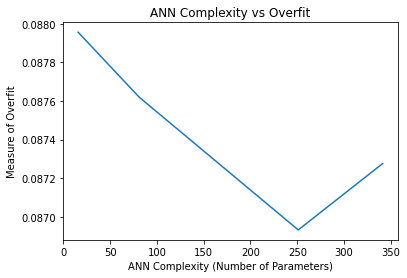

<Figure size 720x360 with 0 Axes>

In [555]:
plt.plot(parameters, overfit)
plt.title('ANN Complexity vs Overfit')
plt.xlabel('ANN Complexity (Number of Parameters)')
plt.ylabel('Measure of Overfit')
figure(figsize=(10,5))
print(parameters)

### Interpretation:
We do observe some decrease in the measure of overfit as ANN complexity increases but according to our hypothesis, the graph should be downward trending throughout. A reason for this discrepancy could be the lack of correlation between AI and Brittleness in this data set which led to poor ANN construction (no clear model of the data). This may indicate that the two variables are independent of eachother. Given a better correlated data set, I expect that the hypothesis will hold. 

### Recommendations:

My recommendation is to explore different Neural Network Architectures (Shrinking, Growing and Shrinking etc) and observe the trends in overfit with increased complexity. It would also be beneficial to carry out this test with a greater number of ANNs  with increasing complexities on different data sets to observe the results. 

I plan to apply this workflow to different data sets, and I would be happy to share my findings.


I hope this was helpful,

*Laaiba Akmal*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
